Airbnb Open data analysis Project
---

This is the first project in the series of Udacity Data scientist nanodegree

#### Goal is to communicate findings from data in a blog in clear manner.

#### Context   
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Boston, MA.

#### Content
The following Airbnb activity is included in this Boston dataset:

Listings, including full descriptions and average review score
Reviews, including unique id for each reviewer and detailed comments
Calendar, including listing id and the price and availability for that day

#### Context   
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Boston, MA.

#### Content
The following Airbnb activity is included in this Boston dataset:

Listings, including full descriptions and average review score
Reviews, including unique id for each reviewer and detailed comments
Calendar, including listing id and the price and availability for that day

Analysis is based on data for 2016.09-2017.09

### Questions to answer from this dataset?


* What is the availabilty of apartments in Boston yearwise (2016.09-2017.09)?
* What are the main factors impacting price?
* What is the sentiment difference in apartment descriptions vs reviews by guests?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk

import pytest
import datetime as dt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn import preprocessing
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  

from wordcloud import WordCloud

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [2]:
path_data = os.getcwd()+'/Data'

In [3]:
calendar = pd.read_csv(path_data+'/calendar.csv')
listings = pd.read_csv(path_data+'/listings.csv')
reviews = pd.read_csv(path_data+'/reviews.csv')

In [4]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [5]:
calendar = calendar.astype({'date':'datetime64[ns]' })

In [6]:
def price_to_int():
    '''
    Converting prices to float after removing dollar sign.
    '''
    calendar['price'] = calendar['price'].replace('\$','',regex = True)
    calendar['price'] = calendar['price'].replace(',','',regex = True)
    calendar['price'] = calendar['price'].replace('\$','',regex = True).astype(float)

    return calendar

def available_to_bool():
    '''
    Convert availabilty to boolean
    '''
    
    
    calendar['available'] = np.where(calendar['available'] == 'f', False,True)
    return calendar

def date_to_datetime():
    calendar['date'] = pd.to_datetime(calendar['date'])
    return calendar

    

In [7]:
calendar = available_to_bool()
calendar = price_to_int()

In [8]:
calendar = calendar.drop_duplicates()

In [9]:
calendar.insert(4,'weekday',value = calendar['date'].dt.weekday)
calendar.insert(5, 'month', value = calendar['date'].dt.month)

In [10]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308525 entries, 0 to 1308889
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308525 non-null  int64         
 1   date        1308525 non-null  datetime64[ns]
 2   available   1308525 non-null  bool          
 3   price       642957 non-null   float64       
 4   weekday     1308525 non-null  int64         
 5   month       1308525 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 61.1 MB


### What is the availabilty of apartments in Boston yearwise (2016.09-2017.09)?

In [11]:
print(round(calendar[calendar['available'] == False].shape[0]/calendar.shape[0],2)*100,'%')

51.0 %


In [12]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
#             _y = p.get_y() + p.get_height()
            _y = p.get_y() + p.get_height() + (p.get_height() *0.01)
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [13]:
sns.set_theme(style = 'dark', context="notebook")

In [36]:
def plot_availability():
    d_dims = (8, 6)
    # df = mylib.load_data()
    fig, ax = plt.subplots(figsize=d_dims)
    total_avail = calendar['available'].value_counts().reset_index()
    total_avail['available %'] = round(total_avail['available']/total_avail['available'].sum()*100,2)

    ax = sns.barplot(data = total_avail, x = 'index', y = 'available %');
    ax.set(xlabel = None)
    ax.set_title('Total availability of Properties (2016.09-2017.09)')
    ax.axhline(0)
    show_values_on_bars(ax)
    fig.savefig('total_availability.png')


In [37]:
def plot_by_timeperiod(time_column, plot_title, x_label, color_x):
    df_count = calendar.groupby(time_column, as_index = False)['available'].sum().rename(columns = {'available':'count'})
    df_count.insert(2,'count /1000', df_count['count']/1000)
    a4_dims = (11.7, 8.27)
    fig, ax2 = plt.subplots(figsize=a4_dims)
    ax2 = sns.barplot(data = df_count, x = time_column, y = 'count /1000', color = color_x);
    ax2.set_title(plot_title);
    ax2.set_xlabel(x_label);
    ax2.set_ylabel('Count /1000');
    show_values_on_bars(ax2);


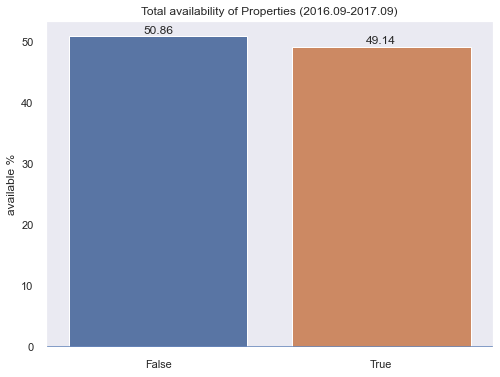

In [38]:
plot_availability()

In [39]:
def plot_by_timeperiod(time_column, plot_title, x_label, color_x,plot_id, axes_x):
    df_count = calendar.groupby(time_column, as_index = False)['available'].sum().rename(columns = {'available':'count'})
    df_count.insert(2,'count /1000', df_count['count']/1000)
    axes[plot_id] = sns.barplot(data = df_count, x = time_column, y = 'count /1000', color = color_x, ax = axes_x);
    axes[plot_id].set_title(plot_title);
    axes[plot_id].set_xlabel(x_label);
    axes[plot_id].set_ylabel('Count /1000');
    show_values_on_bars(axes[plot_id]);

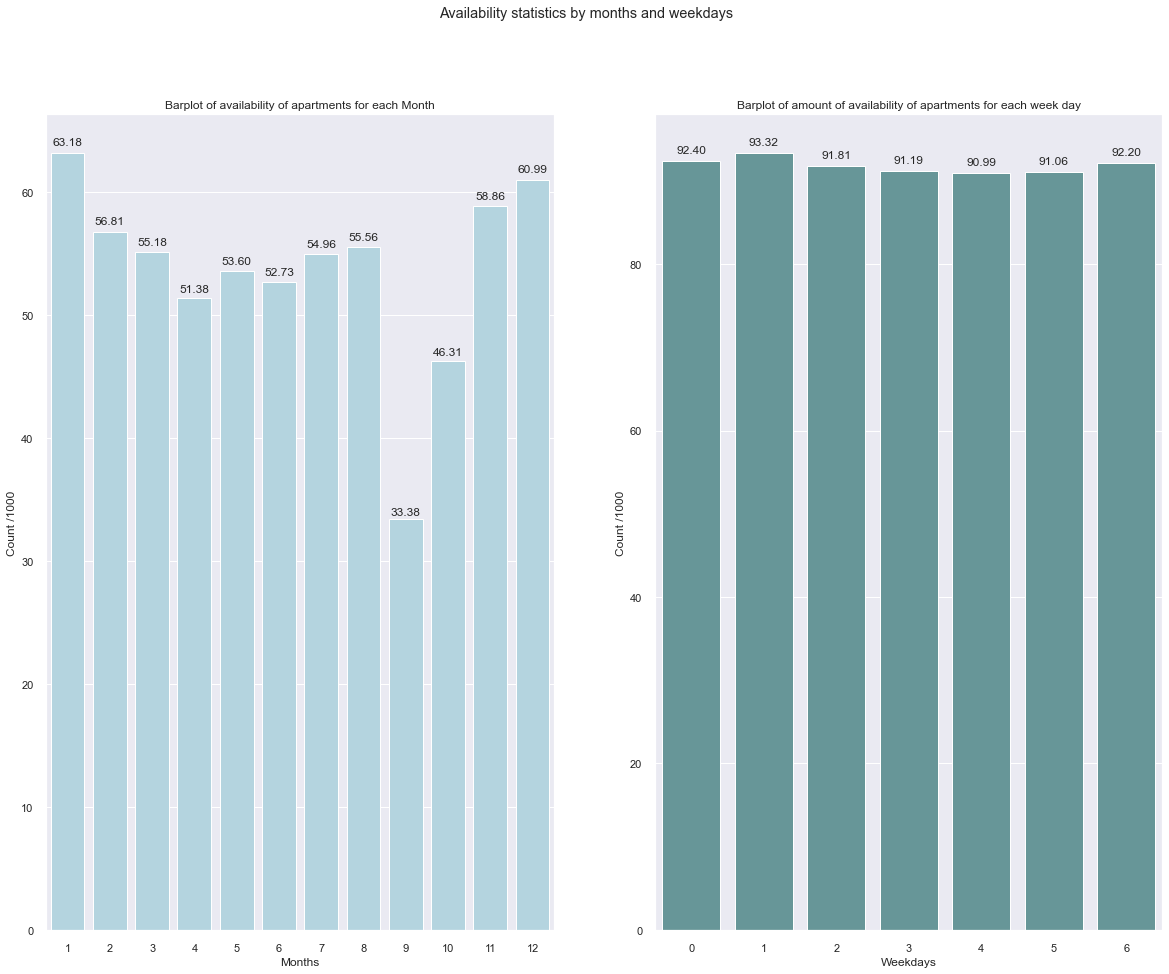

In [89]:
fig, axes = plt.subplots(1,2, figsize = (20,15));
fig.suptitle('Availability statistics by months and weekdays');

plot_by_timeperiod(time_column = 'month',
               plot_title = 'Barplot of availability of apartments for each Month',
               x_label = 'Months',
               color_x = 'lightblue',plot_id = 0, axes_x = axes[0])

plot_by_timeperiod(time_column = 'weekday',
               plot_title = 'Barplot of amount of availability of apartments for each week day',
               x_label = 'Weekdays',
                color_x = 'cadetblue',plot_id = 1, axes_x = axes[1])

fig.savefig('By months and weekdays.png')

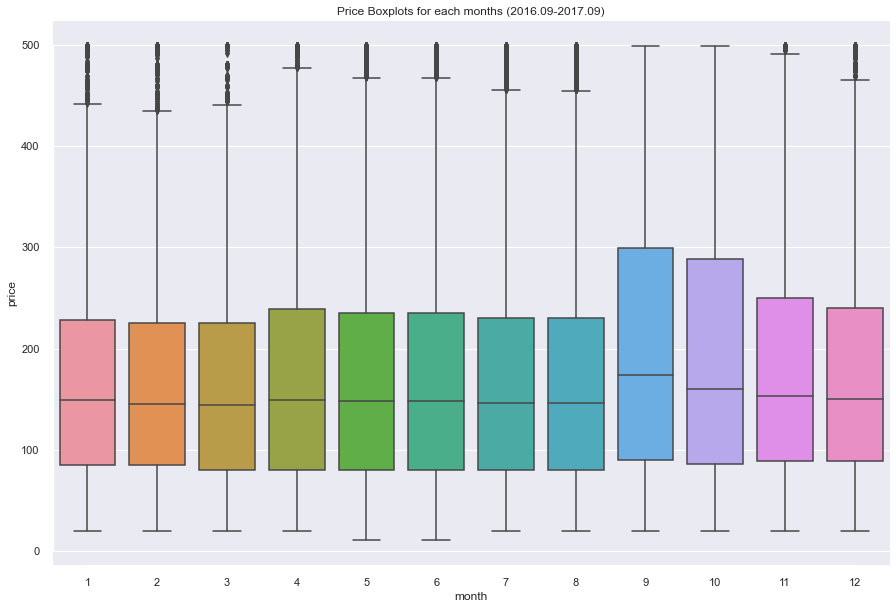

In [44]:
# sns.set_theme(style="ticks", palette="pastel");
d_dims = (15, 10)
fig, ax = plt.subplots(figsize=d_dims)
sns.set_theme(style = 'dark', context="notebook")
# sns.set(title = 'Price Boxplots for each months (2016.09-2017.09)')
sns.set(rc={'figure.figsize':(15,8.27)})
ax = sns.boxplot(data = calendar[calendar['price'] < 500], x = 'month', y = 'price');
ax.set_title('Price Boxplots for each months (2016.09-2017.09)')
sns.despine( trim=True);
fig.savefig('Price by months.png')

### What are the main factors impacting price?

In [45]:
print( round(calendar.loc[calendar['available'] == True]['price'].sum()/1000000,1), 'mln. $' )

127.6 mln. $


In [46]:
market_size = round(calendar.loc[calendar['available'] == True]['price'].sum()/1000000,1)
ave_price = round(calendar.loc[calendar['available'] == True]['price'].sum()/calendar.loc[calendar['available'] == True,:].shape[0],1)
print(f"Market size of Airbnb in Boston is {market_size} mln. $, and average rent price is {ave_price}." )

Market size of Airbnb in Boston is 127.6 mln. $, and average rent price is 198.4.


In [47]:
active_listings = calendar.loc[calendar['available'] == True,'listing_id'].to_list()

In [48]:
listings['neighbourhood_cleansed'].unique()

array(['Roslindale', 'Jamaica Plain', 'Mission Hill',
       'Longwood Medical Area', 'Bay Village', 'Leather District',
       'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay',
       'East Boston', 'Charlestown', 'West End', 'Beacon Hill',
       'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park',
       'Mattapan', 'Dorchester', 'South Boston Waterfront',
       'South Boston', 'Allston'], dtype=object)

In [49]:
listings = listings.loc[listings['id'].isin(active_listings),:]

In [50]:
host_id_counts = listings.groupby('host_id', as_index = False)['id'].count().rename(columns = {'id':'count'})
agents = host_id_counts.loc[host_id_counts['count'] == 1, 'host_id']
listings['agent'] = np.where(listings['host_id'].isin(agents),'agent','firm')

In [51]:
def price_to_int(df):
    '''
    Converting prices to float after removing dollar sign.
    '''
    df['price'] = df['price'].replace('\$','',regex = True)
    df['price'] = df['price'].replace(',','',regex = True)
    df['price'] = df['price'].replace('\$','',regex = True).astype(float)

    return df

listings = price_to_int(df = listings)

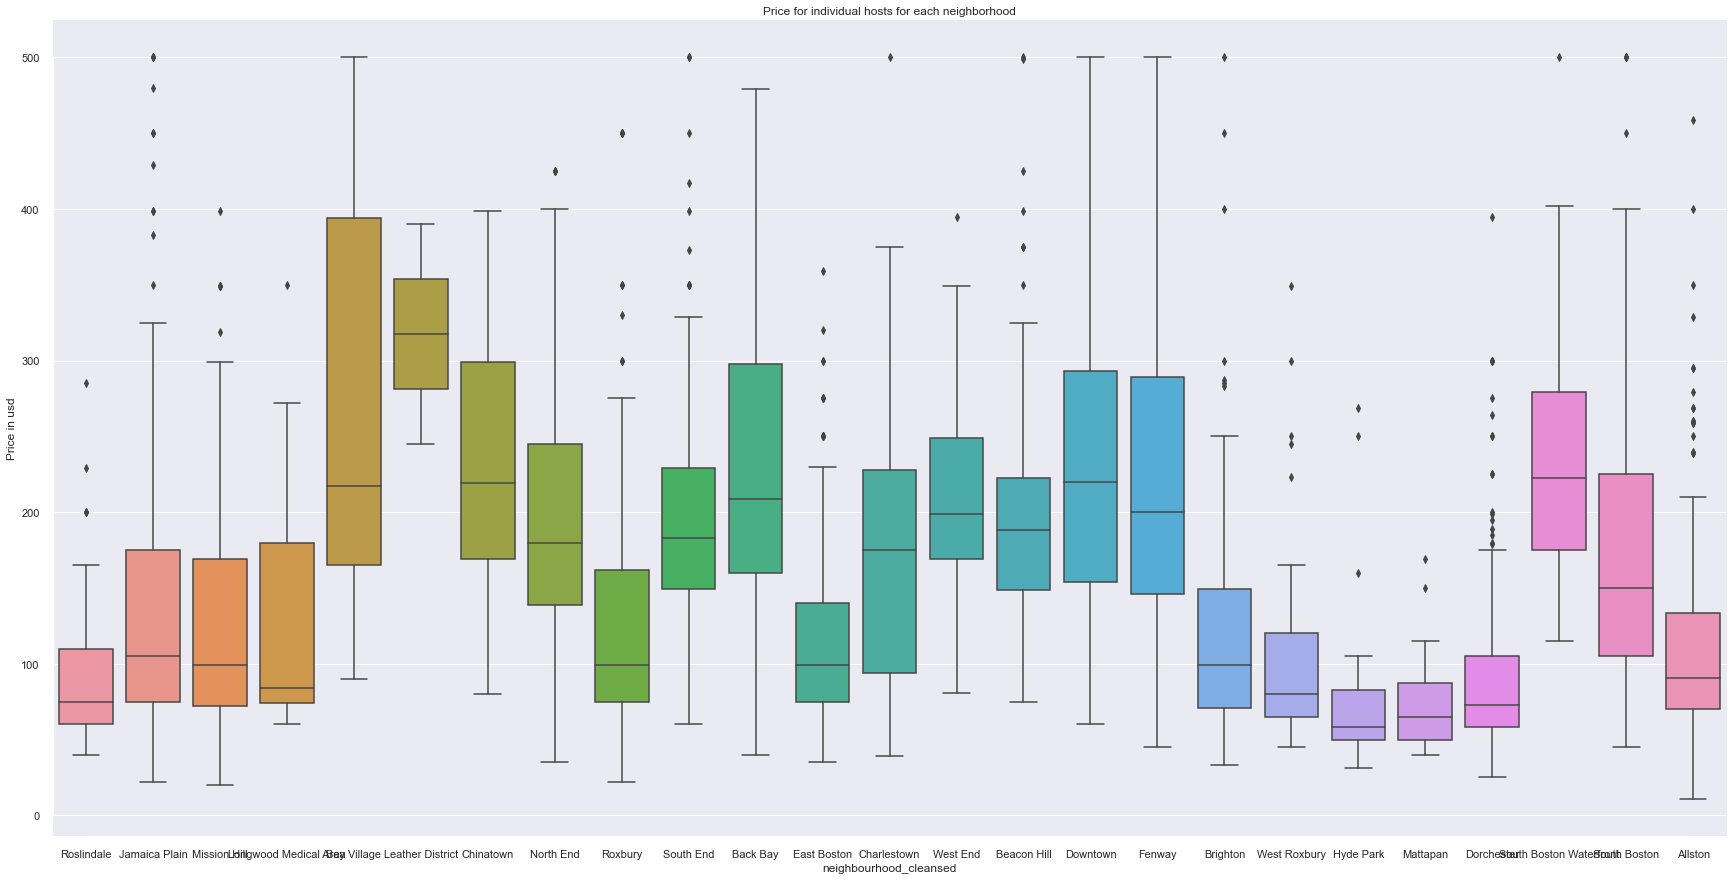

In [91]:
# listings.loc[listings['host_id'].isin(individual_hosts),'total_sum'].plot(kind = 'box');
d_dims = (30,15)
fig, ax = plt.subplots(figsize=d_dims)
sns.set_theme(style = 'dark', context="notebook")
sns.set(rc={'figure.figsize':(35,25)})
columns_filter = (listings['price']<=500)
ax = sns.boxplot(data = listings.loc[columns_filter,:], x = 'neighbourhood_cleansed', y = 'price');
ax.set(ylabel = 'Price in usd')
ax.set(title = 'Price for individual hosts for each neighborhood');
sns.despine( trim=True);
fig.savefig('Price neighborhood.png')

In [60]:
price_impact = listings.loc[:,['host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified',
                              'property_type','accommodates','bathrooms','bedrooms',
                               'beds','bed_type','review_scores_rating','agent','price']]
# 'neighbourhood_cleansed',

In [61]:
y = listings.price

In [62]:
price_impact_num = price_impact.select_dtypes(['float', 'int'])
price_impact_num = price_impact_num.loc[:, price_impact_num.columns != 'price']
price_impact_cat = price_impact.select_dtypes(['object'])


In [63]:
scaler = preprocessing.StandardScaler().fit(price_impact_num)
price_impact_num = pd.DataFrame(scaler.fit_transform(price_impact_num), columns= price_impact_num.columns)

In [64]:
def categorize(evc_x):
    evc_boolean_columns = evc_x.columns[evc_x.nunique() == 2]
    for t in evc_boolean_columns:
        evc_x[t] = np.where(evc_x[t].isin(['t','agent']), True, False)
    evc_non_boolean_columns = list(evc_x.columns[evc_x.nunique() != 2])
    evc_x = pd.get_dummies(data = evc_x,columns = evc_non_boolean_columns)
    evc_x = evc_x[evc_x.columns[~evc_x.columns.str.contains('NoData')]]
    return evc_x

In [65]:
price_impact_cat = categorize(evc_x = price_impact_cat)
price_impact_cat = price_impact_cat.reset_index().drop('index',axis = 1)

<ipython-input-64-bfef6da9b49b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evc_x[t] = np.where(evc_x[t].isin(['t','agent']), True, False)


In [66]:
price_impact = pd.concat([price_impact_cat,price_impact_num], axis = 1)

In [67]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
price_impact = pd.DataFrame(imp.fit_transform(price_impact), columns = price_impact.columns)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(price_impact, y, test_size=0.1, random_state=42)

In [69]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

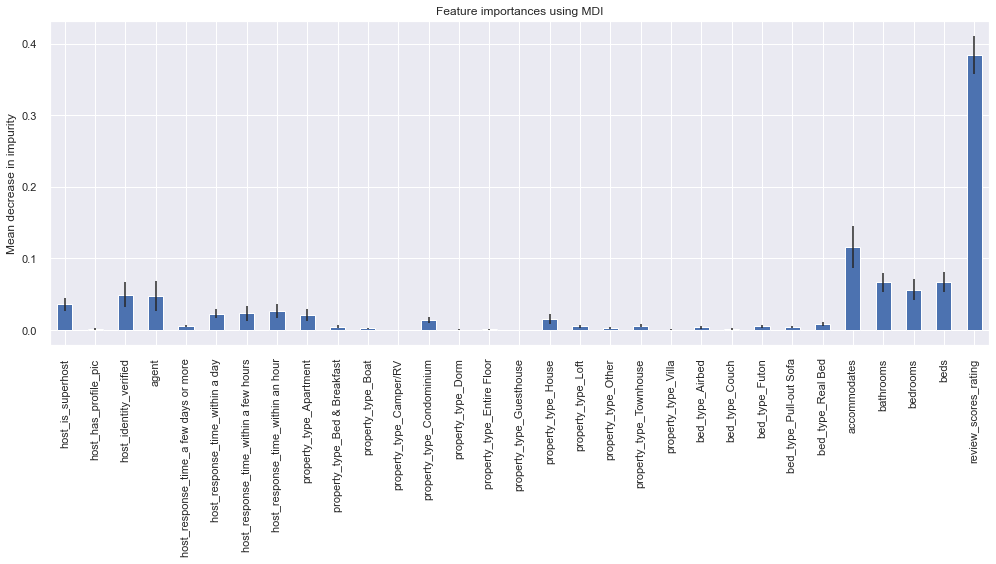

In [71]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=price_impact.columns)

fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [72]:
price_impact.drop('review_scores_rating', axis = 1, inplace = True)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(price_impact, y, test_size=0.1, random_state=42)

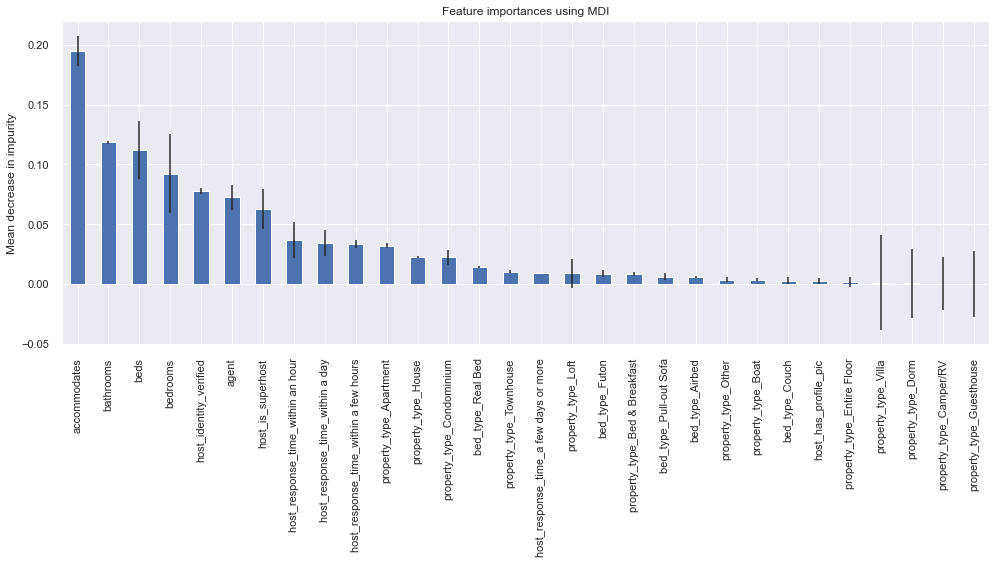

In [75]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=price_impact.columns).sort_values(ascending = False)

fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('feature importance.png')

#### What is the sentiment difference in apartment descriptions vs reviews by guests?

In [76]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308525 entries, 0 to 1308889
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308525 non-null  int64         
 1   date        1308525 non-null  datetime64[ns]
 2   available   1308525 non-null  bool          
 3   price       642957 non-null   float64       
 4   weekday     1308525 non-null  int64         
 5   month       1308525 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 61.1 MB


In [77]:
print(reviews.date.min())
print(reviews.date.max())

2009-03-21
2016-09-06


In [78]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [79]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     68275 non-null  int64         
 1   id             68275 non-null  int64         
 2   date           68275 non-null  datetime64[ns]
 3   reviewer_id    68275 non-null  int64         
 4   reviewer_name  68275 non-null  object        
 5   comments       68222 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.1+ MB


In [80]:
apartments = listings.loc[listings['property_type'] ==  'Apartment','id'].to_list()
apart_reviews = reviews.loc[reviews['listing_id'].isin(apartments),:].copy()
apart_reviews['comments'] = apart_reviews['comments'].fillna('')
apart_reviews['comments_tokenized'] = apart_reviews.apply(lambda row: word_tokenize(row['comments']), axis = 1)

apart_description = listings.loc[listings['property_type'] ==  'Apartment','description'].str.lower().tolist()
apart_comments = apart_reviews['comments'].str.lower().tolist()

In [81]:
stop_words = stopwords.words('english')

In [82]:
def remove_stopwords(sentence):
    word_tokens = word_tokenize(sentence)  
    clean_tokens = [w for w in word_tokens if not w in stop_words]     
    return clean_tokens

def remove_stopwords2(sentence):
#     word_tokens = word_tokenize(sentence)  
    clean_tokens = [w for w in sentence if not w in ['boston', 'apartment', 'area', 'building', 'would']]     
    return clean_tokens

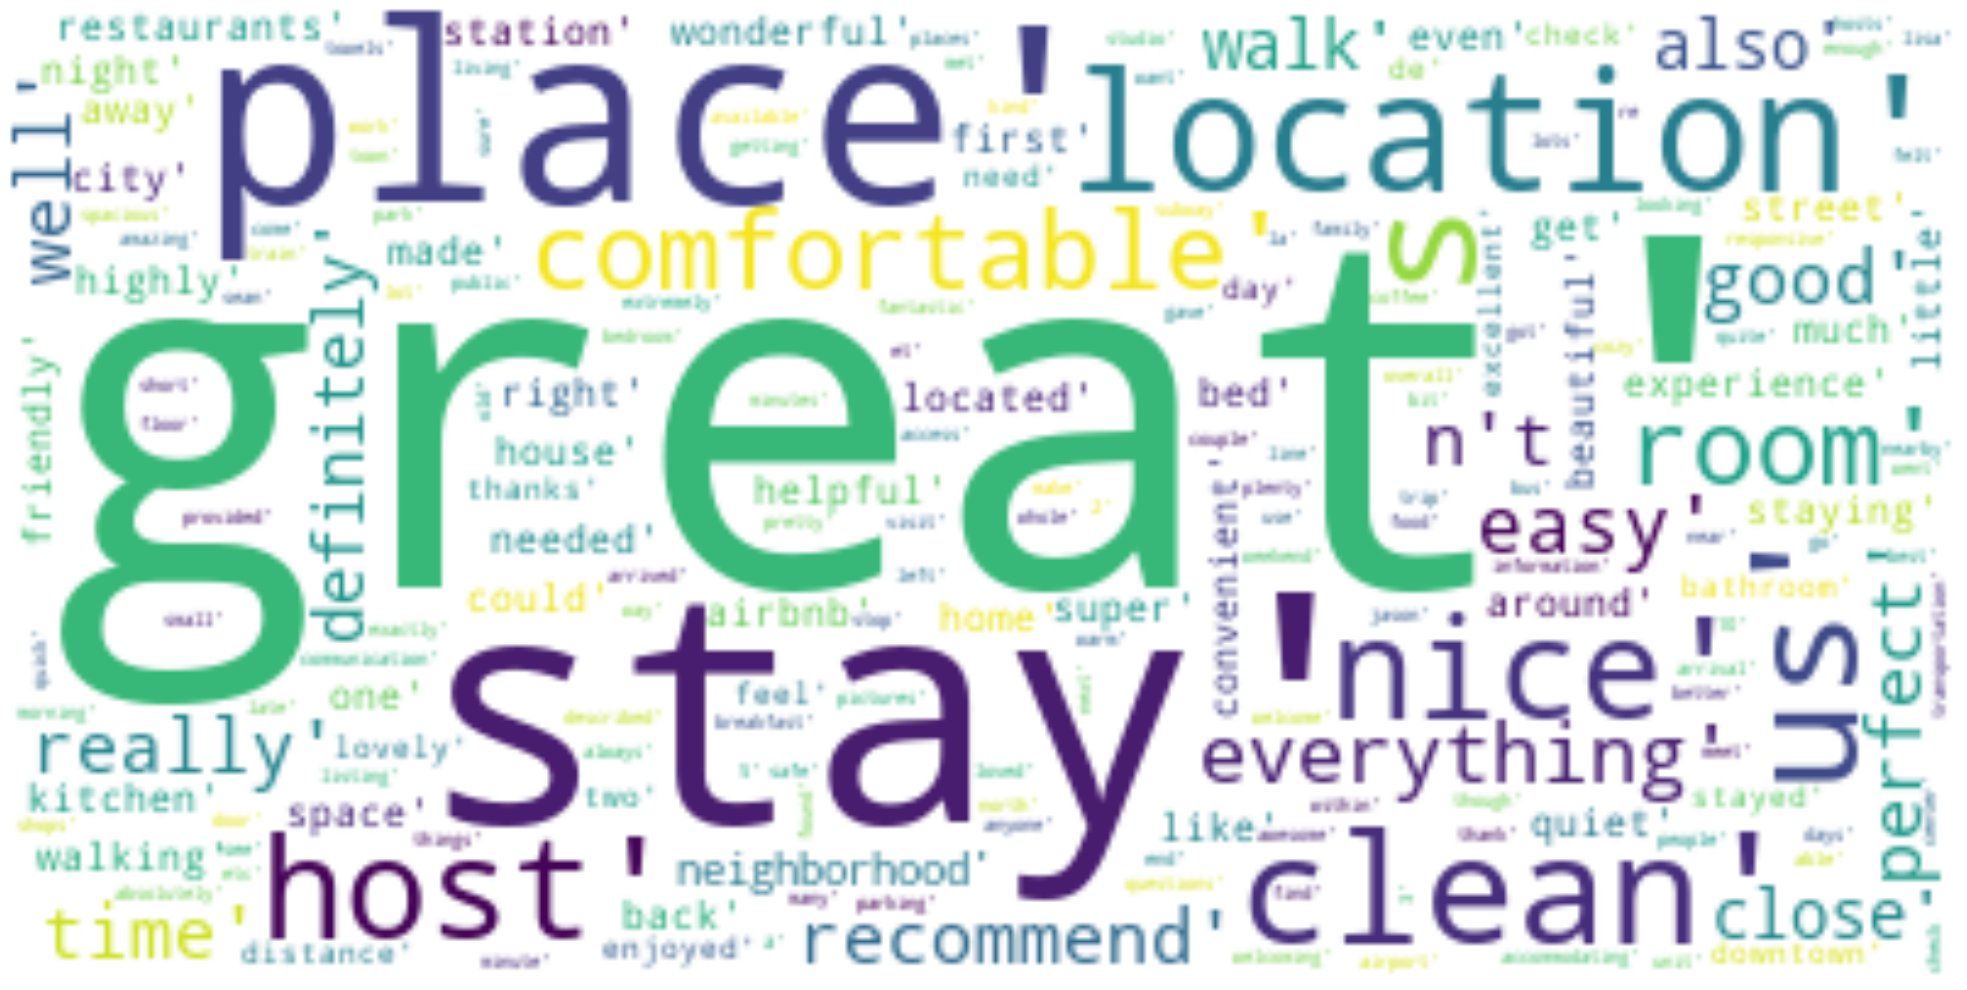

In [88]:
comments = '\n'.join(''.join(list(filter(None.__ne__, i))) for i in apart_comments)
comments_x = remove_stopwords(comments)
comments_x = remove_stopwords2(comments_x)

comments_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(comments_x) )
plt.imshow(comments_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('cloud_comments.png')
plt.show()


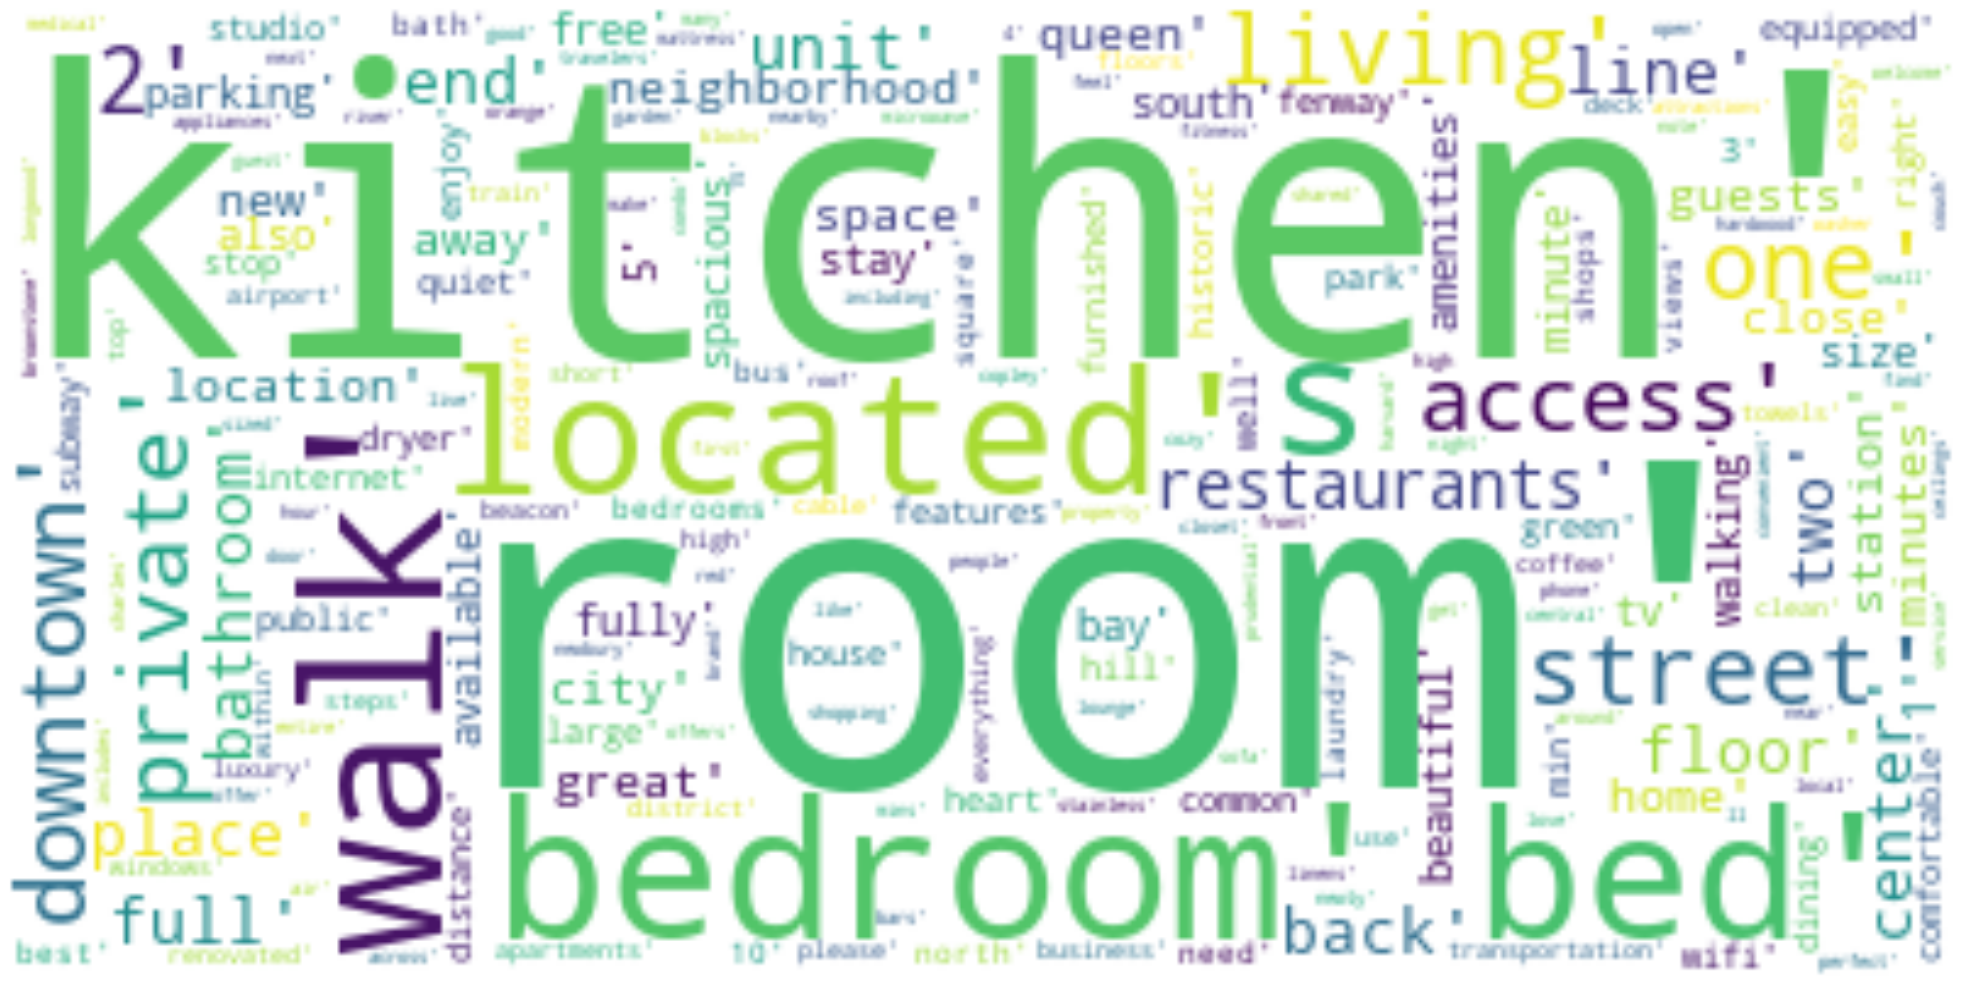

In [87]:
description = '\n'.join(''.join(list(filter(None.__ne__, i))) for i in apart_description)
description_x = remove_stopwords(description)
description_x = remove_stopwords2(description_x)

description_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(description_x) )
plt.imshow(description_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('cloud_description.png')
plt.show()
